In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut

df = pd.read_csv('yearly_player_stats_offense.csv')
print(df.head())

    player_id      player_name position  birth_year  draft_year  draft_round  \
0  00-0000865    Charlie Batch       QB        1974      1998.0          2.0   
1  00-0004541    Donald Driver       WR        1975      1999.0          7.0   
2  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
3  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
4  00-0007091  Matt Hasselbeck       QB        1975      1998.0          6.0   

   draft_pick  draft_ovr  height  weight  ... delta_comp_pct  delta_int_pct  \
0        30.0       60.0    74.0   216.0  ...       0.220036           -1.0   
1         7.0      213.0    72.0   194.0  ...       0.000000            NaN   
2        13.0       13.0    77.0   247.0  ...       0.000000            0.0   
3        13.0       13.0    77.0   247.0  ...       0.000000            NaN   
4        34.0      187.0    76.0   235.0  ...       0.149281           -1.0   

  delta_pass_td_pct delta_ypa delta_yptarget

In [ ]:
print(df.columns.tolist())
num_columns = df.shape[1]

['player_id', 'player_name', 'position', 'birth_year', 'draft_year', 'draft_round', 'draft_pick', 'draft_ovr', 'height', 'weight', 'college', 'season', 'season_type', 'team', 'conference', 'division', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_scramble', 'pass_attempts', 'complete_pass', 'incomplete_pass', 'passing_yards', 'receiving_yards', 'yards_after_catch', 'rush_attempts', 'rushing_yards', 'tackled_for_loss', 'first_down_pass', 'first_down_rush', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'rush_touchdown', 'pass_touchdown', 'safety', 'interception', 'fumble', 'fumble_lost', 'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'receptions', 'targets', 'passing_air_yards', 'receiving_air_yards', 'receiving_touchdown', 'pass_attempts_redzone', 'complete_pass_redzone', 'pass_touchdown_redzone', 'pass_attempts_gtg', 'complete_pass_gtg', 'pass_touchdown_gtg', 'receptions_redzone', 'targets_redzone', 'receiving_touchdown_redzone'

# **DATA CLEANING**

In [ ]:
# For each position, there are different columns that we want to focus on. Therefore, we will keep a separate dataframe for each position.
keep_cols_qbs = [
    'player_id', 'position', 'games_played_season', 'season',
    'season_pass_attempts', 'season_qb_scramble', 'pass_attempts_redzone', 'pass_attempts_gtg', 'season_offense_snaps',
    'passer_rating', 'season_passing_air_yards', 'season_complete_pass', 'season_complete_pass_redzone', 'season_complete_pass_gtg',
    'years_exp', 'games_played_career',
    'draft_ovr', 'draft_round', 'draft_year',
    'fantasy_points_ppr'
]

keep_cols_rbs = [
    'player_id', 'position', 'games_played_season', 'season',
    'season_rush_attempts', 'season_targets', 'season_rush_attempts_redzone', 'season_targets_redzone', 'season_rush_attempts_gtg', 'season_targets_gtg', 'season_offense_snaps',
    'season_receptions', 'season_rushing_yards', 'season_receiving_yards', 'season_yards_after_catch', 'adot',
    'years_exp', 'games_played_career',
    'draft_ovr', 'draft_round', 'draft_year',
    'fantasy_points_ppr'
]

keep_cols_wrs = [
    'player_id', 'position', 'games_played_season', 'season',
    'season_targets', 'season_targets_redzone', 'season_targets_gtg', 'season_offense_snaps',
    'season_receiving_yards', 'season_receptions', 'season_yards_after_catch', 'adot',
    'years_exp', 'games_played_career',
    'draft_ovr', 'draft_round', 'draft_year',
    'fantasy_points_ppr'
]

keep_cols_tes = [
    'player_id', 'position', 'games_played_season', 'season',
    'season_targets', 'season_targets_redzone', 'season_targets_gtg', 'season_offense_snaps',
    'season_receiving_yards', 'season_receptions', 'season_yards_after_catch', 'adot',
    'years_exp', 'games_played_career',
    'draft_ovr', 'draft_round', 'draft_year',
    'fantasy_points_ppr'
]

In [ ]:
## Fixing the draft position for undrafted players. Part of the data cleaning process
# List of positions to adjust
positions = ['QB', 'RB', 'WR', 'TE']

undrafted_pick = {
    1997: 241,
    1998: 242,
    1999: 254,
    2000: 255,
    2001: 247,
    2002: 262,
    2003: 263,
    2004: 256,
    2005: 256,
    2006: 256,
    2007: 256,
    2008: 253,
    2009: 257,
    2010: 256,
    2011: 255,
    2012: 254,
    2013: 255,
    2014: 257,
    2015: 257,
    2016: 254,
    2017: 254,
    2018: 257,
    2019: 255,
    2020: 256,
    2021: 260,
    2022: 263,
    2023: 260,
    2024: 257
}

df['draft_ovr'] = df.apply(
    lambda row: undrafted_pick.get(int(row['draft_year']))
    if pd.isna(row['draft_ovr']) and row['position'] in positions and pd.notna(row['draft_year'])
    else row['draft_ovr'],
    axis=1
)

In [ ]:
df_qbs = df[keep_cols_qbs]
df_rbs = df[keep_cols_rbs]
df_wrs = df[keep_cols_wrs]
df_tes = df[keep_cols_tes]

In [ ]:
# Need to clean each df

# Starting with df_qbs
# Filter the df to only list out QBs that were drafted after 2010 onwards
df_qbs = df_qbs[df_qbs['position'] == "QB"]
df_qbs = df_qbs[df_qbs['season'] > 2010]
# Need to clean the duplicate IDs - after searching through the data, if there is a duplicate ID we will choose the one with more games played (regular season). This made more sense when we looked through the data.
df_qbs['unique_id'] = df_qbs['player_id'].astype(str) + '_' + df_qbs['season'].astype(str)
df_qbs = df_qbs.sort_values(by=['unique_id', 'games_played_season'], ascending=[True, False])
df_qbs = df_qbs.drop_duplicates(subset='unique_id', keep='first')

# We need to change the columns to per game metrics (which will be via creating new columns). -
df_qbs['fantasy_points_ppr_per_game'] = df_qbs['fantasy_points_ppr'] / df_qbs['games_played_season']
df_qbs['pass_attempts_per_game'] = df_qbs['season_pass_attempts'] / df_qbs['games_played_season']
df_qbs['scrambles_per_game'] = df_qbs['season_qb_scramble'] / df_qbs['games_played_season']
df_qbs['redzone_pass_attempts_per_game'] = df_qbs['pass_attempts_redzone'] / df_qbs['games_played_season']
df_qbs['goal_to_go_pass_attempts_per_game'] = df_qbs['pass_attempts_gtg'] / df_qbs['games_played_season']
df_qbs['snaps_per_game'] = df_qbs['season_offense_snaps'] / df_qbs['games_played_season']
df_qbs['passing_air_yards_per_attempt'] = df_qbs['season_passing_air_yards'] / df_qbs['season_pass_attempts']
df_qbs['completion_percentage'] = df_qbs['season_complete_pass'] / df_qbs['season_pass_attempts']
df_qbs['completion_percentage_redzone'] = df_qbs['season_complete_pass_redzone'] / df_qbs['pass_attempts_redzone']
df_qbs['completion_percentage_goal_to_go'] = df_qbs['season_complete_pass_gtg'] / df_qbs['pass_attempts_gtg']

df_qbs.replace([np.inf, -np.inf], np.nan, inplace=True)
df_qbs = df_qbs.dropna()

# Add a final filter on fantasy points per game (ppr), to eliminate quarterbacks that did not play meaningful snaps.
# df_qbs = df_qbs[df_qbs['fantasy_points_ppr_per_game'] > 5]

# Cleaning df_rbs
# Filter the df to only list out RBs that were drafted after 2010 onwards
df_rbs = df_rbs[df_rbs['position'] == "RB"]
df_rbs = df_rbs[df_rbs['season'] > 2010]
# Need to clean the duplicate IDs - after searching through the data, if there is a duplicate ID we will choose the one with more games played (regular season). This made more sense when we looked through the data.
df_rbs['unique_id'] = df_rbs['player_id'].astype(str) + '_' + df_rbs['season'].astype(str)
df_rbs = df_rbs.sort_values(by=['unique_id', 'games_played_season'], ascending=[True, False])
df_rbs = df_rbs.drop_duplicates(subset='unique_id', keep='first')

# We need to change the columns to per game metrics (which will be via creating new columns). -
df_rbs['fantasy_points_ppr_per_game'] = df_rbs['fantasy_points_ppr'] / df_rbs['games_played_season']
df_rbs['rush_attempts_per_game'] = df_rbs['season_rush_attempts'] / df_rbs['games_played_season']
df_rbs['targets_per_game'] = df_rbs['season_targets'] / df_rbs['games_played_season']
df_rbs['redzone_rush_attempts_per_game'] = df_rbs['season_rush_attempts_redzone'] / df_rbs['games_played_season']
df_rbs['redzone_targets_per_game'] = df_rbs['season_targets_redzone'] / df_rbs['games_played_season']
df_rbs['goal_to_go_rush_attempts_per_game'] = df_rbs['season_rush_attempts_gtg'] / df_rbs['games_played_season']
df_rbs['goal_to_go_targets_per_game'] = df_rbs['season_targets_gtg'] / df_rbs['games_played_season']
df_rbs['snaps_per_game'] = df_rbs['season_offense_snaps'] / df_rbs['games_played_season']
df_rbs['yards_per_rush'] = df_rbs['season_rushing_yards'] / df_rbs['season_rush_attempts']
df_rbs['yards_per_reception'] = df_rbs['season_receiving_yards'] / df_rbs['season_receptions']
df_rbs['yards_after_catch_per_reception'] = df_rbs['season_yards_after_catch'] / df_rbs['season_receptions']

# Dropping RBs that do not have a single target, rush, or reception. We are concluding that running backs with these statistics
# are not fantasy relevant, and likely will not have a positive impact on our results.
df_rbs.replace([np.inf, -np.inf], np.nan, inplace=True)
df_rbs = df_rbs.dropna(subset=['adot', 'yards_per_rush', 'yards_per_reception', 'years_exp'])


# Cleaning df_wrs
# Filter the df to only list out WRs that were drafted after 2010 onwards
df_wrs = df_wrs[df_wrs['position'] == "WR"]
df_wrs = df_wrs[df_wrs['season'] > 2010]
# Need to clean the duplicate IDs - after searching through the data, if there is a duplicate ID we will choose the one with more games played (regular season). This made more sense when we looked through the data.
df_wrs['unique_id'] = df_wrs['player_id'].astype(str) + '_' + df_wrs['season'].astype(str)
df_wrs = df_wrs.sort_values(by=['unique_id', 'games_played_season'], ascending=[True, False])
df_wrs = df_wrs.drop_duplicates(subset='unique_id', keep='first')

# We need to change the columns to per game metrics (which will be via creating new columns). -
df_wrs['fantasy_points_ppr_per_game'] = df_wrs['fantasy_points_ppr'] / df_wrs['games_played_season']
df_wrs['targets_per_game'] = df_wrs['season_targets'] / df_wrs['games_played_season']
df_wrs['redzone_targets_per_game'] = df_wrs['season_targets_redzone'] / df_wrs['games_played_season']
df_wrs['goal_to_go_targets_per_game'] = df_wrs['season_targets_gtg'] / df_wrs['games_played_season']
df_wrs['snaps_per_game'] = df_wrs['season_offense_snaps'] / df_wrs['games_played_season']
df_wrs['receiving_yards_per_reception'] = df_wrs['season_receiving_yards'] / df_wrs['season_receptions']
df_wrs['yards_after_catch_per_reception'] = df_wrs['season_yards_after_catch'] / df_wrs['season_receptions']

df_wrs.replace([np.inf, -np.inf], np.nan, inplace=True)
df_wrs = df_wrs.dropna(subset=['adot', 'receiving_yards_per_reception', 'yards_after_catch_per_reception', 'years_exp'])

# Cleaning df_tes
# Filter the df to only list out WRs that were drafted after 2010 onwards
df_tes = df_tes[df_tes['position'] == "TE"]
df_tes = df_tes[df_tes['season'] > 2010]
# Need to clean the duplicate IDs - after searching through the data, if there is a duplicate ID we will choose the one with more games played (regular season). This made more sense when we looked through the data.
df_tes['unique_id'] = df_tes['player_id'].astype(str) + '_' + df_tes['season'].astype(str)
df_tes = df_tes.sort_values(by=['unique_id', 'games_played_season'], ascending=[True, False])
df_tes = df_tes.drop_duplicates(subset='unique_id', keep='first')

# We need to change the columns to per game metrics (which will be via creating new columns). -
df_tes['fantasy_points_ppr_per_game'] = df_tes['fantasy_points_ppr'] / df_tes['games_played_season']
df_tes['targets_per_game'] = df_tes['season_targets'] / df_tes['games_played_season']
df_tes['redzone_targets_per_game'] = df_tes['season_targets_redzone'] / df_tes['games_played_season']
df_tes['goal_to_go_targets_per_game'] = df_tes['season_targets_gtg'] / df_tes['games_played_season']
df_tes['snaps_per_game'] = df_tes['season_offense_snaps'] / df_tes['games_played_season']
df_tes['receiving_yards_per_reception'] = df_tes['season_receiving_yards'] / df_tes['season_receptions']
df_tes['yards_after_catch_per_reception'] = df_tes['season_yards_after_catch'] / df_tes['season_receptions']

df_tes.replace([np.inf, -np.inf], np.nan, inplace=True)
df_tes = df_tes.dropna(subset=['adot', 'receiving_yards_per_reception', 'yards_after_catch_per_reception', 'years_exp'])

# **HELPER FUNCTIONS**

In [ ]:
# Helper function to build the table for each position
def build_ordered_ols_table(models, model_names, volume_vars, efficiency_vars, experience_vars, draft_vars):
    # Define full variable order
    all_vars = ['const'] + volume_vars + efficiency_vars + experience_vars + draft_vars

    # Coefficients and standard errors
    coef_dict = {name: [] for name in model_names}
    for var in all_vars:
        for model, name in zip(models, model_names):
            if var in model.params.index:
                coef = round(model.params[var], 4)
                se = round(model.bse[var], 4)
                coef_dict[name].append(f"{coef}<br>({se})")  # HTML line break
            else:
                coef_dict[name].append("—")

    coef_df = pd.DataFrame(coef_dict, index=all_vars)

    # Model statistics
    stats = ['R-squared', 'Adj. R-squared', 'F-statistic', 'Prob (F-statistic)', 'No. Observations', 'AIC', 'BIC']
    stats_dict = {name: [] for name in model_names}
    for model, name in zip(models, model_names):
        stats_dict[name] = [
            round(model.rsquared, 4),
            round(model.rsquared_adj, 4),
            round(model.fvalue, 4),
            "{:.2e}".format(model.f_pvalue),
            int(model.nobs),
            round(model.aic, 4),
            round(model.bic, 4)
        ]

    stats_df = pd.DataFrame(stats_dict, index=stats)

    # Combine coefficients and statistics
    full_table = pd.concat([coef_df, stats_df])

    # Display as HTML for proper line breaks
    display(HTML(full_table.to_html(escape=False)))
    return full_table

def year_as_fold_validation(df, model_vars, dependent_var='fantasy_points_ppr_per_game',
                            test_years=None):
    """
    Perform cross-validation where each year is a test fold (trained on all other years).

    Parameters:
    -----------
    df : DataFrame
        Your data with a 'season' column
    model_vars : list
        List of independent variables to include in the model
    dependent_var : str
        The dependent variable (y)
    test_years : list or None
        Specific years to use as test sets. If None, uses all available years

    Returns:
    --------
    results : dict
        Dictionary with test year as key, containing model, predictions, and metrics
    """

    # Get all unique years
    all_years = sorted(df['season'].unique())

    if test_years is None:
        test_years = all_years

    results = {}

    for test_year in test_years:
        # Training data: all years EXCEPT test_year
        train_data = df[df['season'] != test_year].copy()
        test_data = df[df['season'] == test_year].copy()

        if len(test_data) == 0:
            print(f"Skipping {test_year}: No test data available")
            continue

        # Prepare X and y for training
        X_train = sm.add_constant(train_data[model_vars])
        y_train = train_data[dependent_var]

        # Prepare X and y for testing
        X_test = sm.add_constant(test_data[model_vars])
        y_test = test_data[dependent_var]

        # Fit model on training data
        model = sm.OLS(y_train, X_train).fit()

        # Make predictions on test data
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[test_year] = {
            'model': model,
            'train_years': [y for y in all_years if y != test_year],
            'n_train': len(train_data),
            'n_test': len(test_data),
            'y_test': y_test,
            'y_pred': y_pred,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_r2': model.rsquared,
            'train_adj_r2': model.rsquared_adj
        }

        print(f"\nTest Year: {test_year}")
        print(f"  Train years: All except {test_year} (n={len(train_data)})")
        print(f"  Test n: {len(test_data)}")
        print(f"  Train R²: {model.rsquared:.4f}")
        print(f"  Test R²: {r2:.4f}")
        print(f"  MSE: {mse:.4f}")

    return results

def time_series_validation(df, model_vars, dependent_var='fantasy_points_ppr_per_game',
                          test_years=None, min_train_years=1):
    """
    Perform time series cross-validation on OLS models.

    Parameters:
    -----------
    df : DataFrame
        Your data with a 'season' column
    model_vars : list
        List of independent variables to include in the model
    dependent_var : str
        The dependent variable (y)
    test_years : list or None
        Specific years to use as test sets. If None, uses all years except the first min_train_years
    min_train_years : int
        Minimum number of years needed in training data

    Returns:
    --------
    results : dict
        Dictionary with test year as key, containing model, predictions, and metrics
    """

    # Get all unique years sorted
    all_years = sorted(df['season'].unique())

    # Determine which years to use as test sets
    if test_years is None:
        # Use all years that have at least min_train_years before them
        test_years = all_years[min_train_years:]

    results = {}

    for test_year in test_years:
        # Training data: all years before test_year
        train_data = df[df['season'] < test_year].copy()
        test_data = df[df['season'] == test_year].copy()

        # Skip if not enough training data
        if len(train_data) == 0:
            print(f"Skipping {test_year}: No training data available")
            continue

        if len(test_data) == 0:
            print(f"Skipping {test_year}: No test data available")
            continue

        # Prepare X and y for training
        X_train = sm.add_constant(train_data[model_vars])
        y_train = train_data[dependent_var]

        # Prepare X and y for testing
        X_test = sm.add_constant(test_data[model_vars])
        y_test = test_data[dependent_var]

        # Fit model on training data
        model = sm.OLS(y_train, X_train).fit()

        # Make predictions on test data
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[test_year] = {
            'model': model,
            'train_years': list(train_data['season'].unique()),
            'n_train': len(train_data),
            'n_test': len(test_data),
            'y_test': y_test,
            'y_pred': y_pred,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_r2': model.rsquared,
            'train_adj_r2': model.rsquared_adj
        }

        print(f"\nTest Year: {test_year}")
        print(f"  Train years: {min(train_data['season'])} - {max(train_data['season'])} (n={len(train_data)})")
        print(f"  Test n: {len(test_data)}")
        print(f"  Train R²: {model.rsquared:.4f}")
        print(f"  Test R²: {r2:.4f}")
        print(f"  MSE: {mse:.4f}")

    return results

def rolling_window_validation(df, model_vars, dependent_var='fantasy_points_ppr_per_game',
                              window_size=5):
    """
    Perform rolling window time series cross-validation.
    Train on a fixed window of years, test on the next year.

    Parameters:
    -----------
    df : DataFrame
        Your data with a 'season' column
    model_vars : list
        List of independent variables to include in the model
    dependent_var : str
        The dependent variable (y)
    window_size : int
        Number of years to use for training (default 4)

    Returns:
    --------
    results : dict
        Dictionary with test year as key, containing model, predictions, and metrics
    """

    # Get all unique years sorted
    all_years = sorted(df['season'].unique())

    # Need at least window_size + 1 years total
    if len(all_years) < window_size + 1:
        print(f"Not enough years. Need at least {window_size + 1}, have {len(all_years)}")
        return {}

    results = {}

    # Start from window_size (so we have enough years to train on)
    for i in range(window_size, len(all_years)):
        test_year = all_years[i]
        train_years = all_years[i-window_size:i]  # Get the previous window_size years

        # Training data: only the years in the window
        train_data = df[df['season'].isin(train_years)].copy()
        test_data = df[df['season'] == test_year].copy()

        if len(train_data) == 0:
            print(f"Skipping {test_year}: No training data available")
            continue

        if len(test_data) == 0:
            print(f"Skipping {test_year}: No test data available")
            continue

        # Prepare X and y for training
        X_train = sm.add_constant(train_data[model_vars])
        y_train = train_data[dependent_var]

        # Prepare X and y for testing
        X_test = sm.add_constant(test_data[model_vars])
        y_test = test_data[dependent_var]

        # Fit model on training data
        model = sm.OLS(y_train, X_train).fit()

        # Make predictions on test data
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[test_year] = {
            'model': model,
            'train_years': train_years,
            'n_train': len(train_data),
            'n_test': len(test_data),
            'y_test': y_test,
            'y_pred': y_pred,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_r2': model.rsquared,
            'train_adj_r2': model.rsquared_adj
        }

        print(f"\nTest Year: {test_year}")
        print(f"  Train years: {min(train_years)} - {max(train_years)} (n={len(train_data)})")
        print(f"  Test n: {len(test_data)}")
        print(f"  Train R²: {model.rsquared:.4f}")
        print(f"  Test R²: {r2:.4f}")
        print(f"  MSE: {mse:.4f}")

    return results

# **QBS**

In [ ]:
volume_vars = [
    'pass_attempts_per_game', 'scrambles_per_game',
    'redzone_pass_attempts_per_game', 'goal_to_go_pass_attempts_per_game',
    'snaps_per_game'
]

efficiency_vars = [
    'passer_rating', 'passing_air_yards_per_attempt', 'completion_percentage',
    'completion_percentage_redzone', 'completion_percentage_goal_to_go'
]

experience_vars = [
    'years_exp', 'games_played_career'
]

draft_vars = [
    'draft_ovr'
]

In [ ]:
# Table for QBs

# Define your dependent variable
y = df_qbs['fantasy_points_ppr_per_game']

# Model 1: Volume only
X1 = sm.add_constant(df_qbs[volume_vars])
model1 = sm.OLS(y, X1).fit()

# Model 2: Volume + Efficiency
X2 = sm.add_constant(df_qbs[volume_vars + efficiency_vars])
model2 = sm.OLS(y, X2).fit()

# Model 3: Volume + Efficiency + Experience
X3 = sm.add_constant(df_qbs[volume_vars + efficiency_vars + experience_vars])
model3 = sm.OLS(y, X3).fit()

# Model 4: Volume + Efficiency + Experience + Draft
X4 = sm.add_constant(df_qbs[volume_vars + efficiency_vars + experience_vars + draft_vars])
model4 = sm.OLS(y, X4).fit()

# Print results
# print("=== Model 1: Volume Only ===")
# print(model1.summary())
# print("\n=== Model 2: Volume + Efficiency ===")
# print(model2.summary())
# print("\n=== Model 3: Volume + Efficiency + Experience ===")
# print(model3.summary())
# print("\n=== Model 4: Volume + Efficiency + Experience + Draft ===")
# print(model4.summary())

# Creating the combined table for each model
models = [model1, model2, model3, model4]
model_names = ["Volume Only", "Volume + Efficiency", "Volume + Efficiency + Experience", "Volume + Efficiency + Experience + Draft"]
full_ols_table = build_ordered_ols_table(models, model_names, volume_vars, efficiency_vars, experience_vars, draft_vars)
full_ols_table_clean = full_ols_table.replace({'<br>': ' '}, regex=True)
full_ols_table_clean.to_csv("ols_results_clean_qbs.csv", index=True)

,Volume Only,Volume + Efficiency,Volume + Efficiency + Experience,Volume + Efficiency + Experience + Draft
const,-3.7128(0.6258),-15.4547(1.4869),-15.0441(1.4856),-14.4921(1.4973)
pass_attempts_per_game,-0.1157(0.0558),0.1252(0.0426),0.124(0.0426),0.1228(0.0425)
scrambles_per_game,1.3692(0.1759),1.2896(0.1282),1.3324(0.1355),1.3563(0.1353)
redzone_pass_attempts_per_game,1.7439(0.1814),0.7218(0.1439),0.6853(0.1439),0.7039(0.1435)
goal_to_go_pass_attempts_per_game,1.7687(0.4419),1.3775(0.3342),1.3866(0.3323),1.3494(0.3313)
snaps_per_game,0.231(0.0317),0.1202(0.0238),0.1164(0.024),0.1116(0.0239)
passer_rating,—,0.2009(0.0114),0.1977(0.0113),0.1977(0.0113)
passing_air_yards_per_attempt,—,0.5015(0.0862),0.5231(0.086),0.5197(0.0857)
completion_percentage,—,-9.0913(2.4697),-9.8533(2.4712),-9.9509(2.4614)
completion_percentage_redzone,—,-2.2811(0.9184),-2.0448(0.9166),-1.9572(0.9135)


In [ ]:
from google.colab import files
files.download("ols_results_clean_qbs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# K-Fold - Leave One Group Out Cross Validation
# Usage for QBs
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run year-as-fold validation on QBs
results_qb_year_fold = year_as_fold_validation(
    df_qbs,
    all_model_vars,
    test_years=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]  # Will test on all years from 2012-2024
)

# Get summary statistics
test_mses = [r['mse'] for r in results_qb_year_fold.values()]
test_r2s = [r['r2'] for r in results_qb_year_fold.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY - YEAR AS FOLD")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Create appendix table for year-as-fold validation results
validation_results = []

for test_year, result in results_qb_year_fold.items():
    # Extract train years (all years except test year)
    all_years = list(range(2012, 2025))
    train_years = [y for y in all_years if y != test_year]

    # Format train years showing the gap
    if test_year == min(all_years):
        train_range = f"{min(train_years)}-{max(train_years)}"
    elif test_year == max(all_years):
        train_range = f"{min(train_years)}-{max(train_years)}"
    else:
        # Show gap: e.g., "2012-2012, 2014-2024" for test_year=2013
        before = [y for y in train_years if y < test_year]
        after = [y for y in train_years if y > test_year]

        if before and after:
            train_range = f"{min(before)}-{max(before)}, {min(after)}-{max(after)}"
        elif before:
            train_range = f"{min(before)}-{max(before)}"
        else:
            train_range = f"{min(after)}-{max(after)}"

    validation_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
validation_table = pd.DataFrame(validation_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

validation_table_full = pd.concat([validation_table, summary_row], ignore_index=True)

print("\nTable AX: Leave-One-Year-Out Cross-Validation Results")
print("="*70)
print(validation_table_full.to_string(index=False))
print("="*70)
print("Note: Each row represents a separate model trained on all years except the test year.")

# Save to CSV
validation_table_full.to_csv('appendix_table_validation_kfold_qb.csv', index=False)


Test Year: 2012
  Train years: All except 2012 (n=550)
  Test n: 40
  Train R²: 0.8538
  Test R²: 0.7573
  MSE: 8.5973

Test Year: 2013
  Train years: All except 2013 (n=551)
  Test n: 39
  Train R²: 0.8465
  Test R²: 0.8775
  MSE: 4.6604

Test Year: 2014
  Train years: All except 2014 (n=548)
  Test n: 42
  Train R²: 0.8435
  Test R²: 0.9337
  MSE: 2.1070

Test Year: 2015
  Train years: All except 2015 (n=548)
  Test n: 42
  Train R²: 0.8508
  Test R²: 0.7907
  MSE: 7.4980

Test Year: 2016
  Train years: All except 2016 (n=547)
  Test n: 43
  Train R²: 0.8491
  Test R²: 0.8345
  MSE: 6.7872

Test Year: 2017
  Train years: All except 2017 (n=540)
  Test n: 50
  Train R²: 0.8493
  Test R²: 0.8302
  MSE: 5.7080

Test Year: 2018
  Train years: All except 2018 (n=547)
  Test n: 43
  Train R²: 0.8438
  Test R²: 0.8970
  MSE: 3.9578

Test Year: 2019
  Train years: All except 2019 (n=548)
  Test n: 42
  Train R²: 0.8492
  Test R²: 0.8299
  MSE: 6.2084

Test Year: 2020
  Train years: All exce

In [ ]:
# Time series validation without a set window size
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run time series validation
results_qb = time_series_validation(
    df_qbs,
    all_model_vars,
    test_years=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    min_train_years=2
)

# Get summary statistics across all test years
test_mses = [r['mse'] for r in results_qb.values()]
test_r2s = [r['r2'] for r in results_qb.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Create appendix table for time series validation results
time_series_results = []

for test_year, result in results_qb.items():
    # Train years are all years before test year (with min_train_years=2)
    first_train_year = 2012  # Adjust if your data starts differently
    train_range = f"{first_train_year}-{test_year - 1}"

    time_series_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
time_series_table = pd.DataFrame(time_series_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

time_series_table_full = pd.concat([time_series_table, summary_row], ignore_index=True)

print("\nTime Series Cross-Validation Results")
print("="*70)
print(time_series_table_full.to_string(index=False))
print("="*70)
print("Note: Each model is trained on all years up to (but not including) the test year.")
print("Minimum of 2 training years required.")

# Save to CSV
time_series_table_full.to_csv('appendix_table_time_series_validation_qb.csv', index=False)


Test Year: 2014
  Train years: 2012 - 2013 (n=79)
  Test n: 42
  Train R²: 0.8634
  Test R²: 0.6711
  MSE: 10.4604

Test Year: 2015
  Train years: 2012 - 2014 (n=121)
  Test n: 42
  Train R²: 0.8733
  Test R²: 0.8530
  MSE: 5.2681

Test Year: 2016
  Train years: 2012 - 2015 (n=163)
  Test n: 43
  Train R²: 0.8771
  Test R²: 0.7921
  MSE: 8.5236

Test Year: 2017
  Train years: 2012 - 2016 (n=206)
  Test n: 50
  Train R²: 0.8678
  Test R²: 0.7816
  MSE: 7.3421

Test Year: 2018
  Train years: 2012 - 2017 (n=256)
  Test n: 43
  Train R²: 0.8575
  Test R²: 0.8944
  MSE: 4.0582

Test Year: 2019
  Train years: 2012 - 2018 (n=299)
  Test n: 42
  Train R²: 0.8661
  Test R²: 0.8172
  MSE: 6.6721

Test Year: 2020
  Train years: 2012 - 2019 (n=341)
  Test n: 49
  Train R²: 0.8622
  Test R²: 0.8044
  MSE: 12.3684

Test Year: 2021
  Train years: 2012 - 2020 (n=390)
  Test n: 47
  Train R²: 0.8564
  Test R²: 0.8492
  MSE: 5.1754

Test Year: 2022
  Train years: 2012 - 2021 (n=437)
  Test n: 46
  Trai

In [ ]:
# Rolling window of 5 years
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run rolling window validation
results_qb_rolling = rolling_window_validation(
    df_qbs,
    all_model_vars,
    window_size=5
)

# Get summary statistics
test_mses = [r['mse'] for r in results_qb_rolling.values()]
test_r2s = [r['r2'] for r in results_qb_rolling.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY - ROLLING WINDOW (4 years)")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Appendix Table
rolling_results = []

for test_year, result in results_qb_rolling.items():
    # Train years are the 5 years before test year
    train_start = test_year - 5
    train_end = test_year - 1
    train_range = f"{train_start}-{train_end}"

    rolling_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
rolling_table = pd.DataFrame(rolling_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

rolling_table_full = pd.concat([rolling_table, summary_row], ignore_index=True)

print("\nTable A#: Rolling Window Cross-Validation Results (5-Year Window)")
print("="*70)
print(rolling_table_full.to_string(index=False))
print("="*70)
print("Note: Each model is trained on a rolling 5-year window immediately preceding the test year.")

# Save to CSV
rolling_table_full.to_csv('appendix_table_rolling_validation_qb.csv', index=False)


Test Year: 2017
  Train years: 2012 - 2016 (n=206)
  Test n: 50
  Train R²: 0.8678
  Test R²: 0.7816
  MSE: 7.3421

Test Year: 2018
  Train years: 2013 - 2017 (n=216)
  Test n: 43
  Train R²: 0.8761
  Test R²: 0.8923
  MSE: 4.1409

Test Year: 2019
  Train years: 2014 - 2018 (n=220)
  Test n: 42
  Train R²: 0.8791
  Test R²: 0.8277
  MSE: 6.2885

Test Year: 2020
  Train years: 2015 - 2019 (n=220)
  Test n: 49
  Train R²: 0.8635
  Test R²: 0.8180
  MSE: 11.5084

Test Year: 2021
  Train years: 2016 - 2020 (n=227)
  Test n: 47
  Train R²: 0.8713
  Test R²: 0.7688
  MSE: 7.9320

Test Year: 2022
  Train years: 2017 - 2021 (n=231)
  Test n: 46
  Train R²: 0.8683
  Test R²: 0.7763
  MSE: 7.1255

Test Year: 2023
  Train years: 2018 - 2022 (n=227)
  Test n: 52
  Train R²: 0.8586
  Test R²: 0.5333
  MSE: 22.7892

Test Year: 2024
  Train years: 2019 - 2023 (n=236)
  Test n: 55
  Train R²: 0.8263
  Test R²: 0.8915
  MSE: 5.1946

OVERALL SUMMARY - ROLLING WINDOW (4 years)
Average Test MSE: 9.0401 (

# **RBS**

In [ ]:
volume_vars = [
    'rush_attempts_per_game', 'targets_per_game', 'redzone_rush_attempts_per_game', 'redzone_targets_per_game',
    'goal_to_go_rush_attempts_per_game', 'goal_to_go_targets_per_game', 'snaps_per_game'
]

efficiency_vars = [
    'yards_per_rush', 'yards_per_reception', 'yards_after_catch_per_reception', 'adot'
]

experience_vars = [
    'years_exp', 'games_played_career'
]

draft_vars = [
    'draft_ovr'
]

In [ ]:
# Table for RBs

# Define your dependent variable
y = df_rbs['fantasy_points_ppr_per_game']

# Model 1: Volume only
X1 = sm.add_constant(df_rbs[volume_vars])
model1 = sm.OLS(y, X1).fit()

# Model 2: Volume + Efficiency
X2 = sm.add_constant(df_rbs[volume_vars + efficiency_vars])
model2 = sm.OLS(y, X2).fit()

# Model 3: Volume + Efficiency + Experience
X3 = sm.add_constant(df_rbs[volume_vars + efficiency_vars + experience_vars])
model3 = sm.OLS(y, X3).fit()

# Model 4: Volume + Efficiency + Experience + Draft
X4 = sm.add_constant(df_rbs[volume_vars + efficiency_vars + experience_vars + draft_vars])
model4 = sm.OLS(y, X4).fit()

# Creating the combined table
models = [model1, model2, model3, model4]
model_names = ["Volume Only", "Volume + Efficiency", "Volume + Efficiency + Experience", "Volume + Efficiency + Experience + Draft"]
full_ols_table = build_ordered_ols_table(models, model_names, volume_vars, efficiency_vars, experience_vars, draft_vars)
full_ols_table_clean = full_ols_table.replace({'<br>': ' '}, regex=True)
full_ols_table_clean.to_csv("ols_results_clean_rbs.csv", index=True)


,Volume Only,Volume + Efficiency,Volume + Efficiency + Experience,Volume + Efficiency + Experience + Draft
const,-0.4979(0.1135),-3.4581(0.1922),-3.3489(0.1988),-3.554(0.24)
rush_attempts_per_game,0.4419(0.0272),0.4231(0.0243),0.4231(0.0244),0.4284(0.0246)
targets_per_game,1.4651(0.0743),1.446(0.0659),1.4363(0.0659),1.4401(0.0659)
redzone_rush_attempts_per_game,0.9443(0.1364),0.8501(0.1209),0.837(0.121),0.8336(0.121)
redzone_targets_per_game,1.1348(0.2789),1.1468(0.247),1.1756(0.2476),1.1792(0.2475)
goal_to_go_rush_attempts_per_game,0.9021(0.2595),1.1358(0.2307),1.1438(0.2304),1.146(0.2303)
goal_to_go_targets_per_game,1.5134(0.7277),1.1636(0.6442),1.2075(0.6442),1.2066(0.6439)
snaps_per_game,-0.0161(0.013),-0.0163(0.0116),-0.015(0.0116),-0.0147(0.0116)
yards_per_rush,—,0.5497(0.0351),0.5442(0.0351),0.5426(0.0351)
yards_per_reception,—,0.1819(0.0306),0.1839(0.0305),0.1857(0.0306)


In [ ]:
from google.colab import files
files.download("ols_results_clean_rbs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# K-Fold - Leave One Group Out Cross Validation
# Usage for RBs
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run year-as-fold validation on RBs
results_rb_year_fold = year_as_fold_validation(
    df_rbs,
    all_model_vars,
    test_years=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]  # Will test on all years from 2012-2024
)

# Get summary statistics
test_mses = [r['mse'] for r in results_rb_year_fold.values()]
test_r2s = [r['r2'] for r in results_rb_year_fold.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY - YEAR AS FOLD")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Create appendix table for year-as-fold validation results
validation_results = []

for test_year, result in results_rb_year_fold.items():
    # Extract train years (all years except test year)
    all_years = list(range(2012, 2025))
    train_years = [y for y in all_years if y != test_year]

    # Format train years showing the gap
    if test_year == min(all_years):
        train_range = f"{min(train_years)}-{max(train_years)}"
    elif test_year == max(all_years):
        train_range = f"{min(train_years)}-{max(train_years)}"
    else:
        # Show gap: e.g., "2012-2012, 2014-2024" for test_year=2013
        before = [y for y in train_years if y < test_year]
        after = [y for y in train_years if y > test_year]

        if before and after:
            train_range = f"{min(before)}-{max(before)}, {min(after)}-{max(after)}"
        elif before:
            train_range = f"{min(before)}-{max(before)}"
        else:
            train_range = f"{min(after)}-{max(after)}"

    validation_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
validation_table = pd.DataFrame(validation_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

validation_table_full = pd.concat([validation_table, summary_row], ignore_index=True)

print("\Leave-One-Year-Out Cross-Validation Results")
print("="*70)
print(validation_table_full.to_string(index=False))
print("="*70)
print("Note: Each row represents a separate model trained on all years except the test year.")

# Save to CSV
validation_table_full.to_csv('appendix_table_validation_kfold_rb.csv', index=False)

<>:68: SyntaxWarning: invalid escape sequence '\L'
<>:68: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipython-input-9093701.py:68: SyntaxWarning: invalid escape sequence '\L'
  print("\Leave-One-Year-Out Cross-Validation Results")



Test Year: 2012
  Train years: All except 2012 (n=1247)
  Test n: 88
  Train R²: 0.8992
  Test R²: 0.9226
  MSE: 1.8536

Test Year: 2013
  Train years: All except 2013 (n=1245)
  Test n: 90
  Train R²: 0.9011
  Test R²: 0.8883
  MSE: 3.1434

Test Year: 2014
  Train years: All except 2014 (n=1247)
  Test n: 88
  Train R²: 0.9027
  Test R²: 0.8560
  MSE: 3.6907

Test Year: 2015
  Train years: All except 2015 (n=1244)
  Test n: 91
  Train R²: 0.9005
  Test R²: 0.9018
  MSE: 2.3579

Test Year: 2016
  Train years: All except 2016 (n=1246)
  Test n: 89
  Train R²: 0.9024
  Test R²: 0.8786
  MSE: 3.9031

Test Year: 2017
  Train years: All except 2017 (n=1239)
  Test n: 96
  Train R²: 0.9030
  Test R²: 0.8553
  MSE: 3.5322

Test Year: 2018
  Train years: All except 2018 (n=1226)
  Test n: 109
  Train R²: 0.8996
  Test R²: 0.9032
  MSE: 3.2212

Test Year: 2019
  Train years: All except 2019 (n=1224)
  Test n: 111
  Train R²: 0.8990
  Test R²: 0.9153
  MSE: 2.3854

Test Year: 2020
  Train years

In [ ]:
# Predictive power of OLS model
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run time series validation
results_rb = time_series_validation(
    df_rbs,
    all_model_vars,
    test_years=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    min_train_years=2
)

# Get summary statistics across all test years
test_mses = [r['mse'] for r in results_rb.values()]
test_r2s = [r['r2'] for r in results_rb.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Create appendix table for time series validation results
time_series_results = []

for test_year, result in results_rb.items():
    # Train years are all years before test year (with min_train_years=2)
    first_train_year = 2012  # Adjust if your data starts differently
    train_range = f"{first_train_year}-{test_year - 1}"

    time_series_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
time_series_table = pd.DataFrame(time_series_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

time_series_table_full = pd.concat([time_series_table, summary_row], ignore_index=True)

print("\nTime Series Cross-Validation Results")
print("="*70)
print(time_series_table_full.to_string(index=False))
print("="*70)
print("Note: Each model is trained on all years up to (but not including) the test year.")
print("Minimum of 2 training years required.")

# Save to CSV
time_series_table_full.to_csv('rb_time_series_validation.csv', index=False)


Test Year: 2014
  Train years: 2012 - 2013 (n=178)
  Test n: 88
  Train R²: 0.9256
  Test R²: 0.8863
  MSE: 2.9140

Test Year: 2015
  Train years: 2012 - 2014 (n=266)
  Test n: 91
  Train R²: 0.9224
  Test R²: 0.9011
  MSE: 2.3748

Test Year: 2016
  Train years: 2012 - 2015 (n=357)
  Test n: 89
  Train R²: 0.9185
  Test R²: 0.8685
  MSE: 4.2306

Test Year: 2017
  Train years: 2012 - 2016 (n=446)
  Test n: 96
  Train R²: 0.9081
  Test R²: 0.7960
  MSE: 4.9823

Test Year: 2018
  Train years: 2012 - 2017 (n=542)
  Test n: 109
  Train R²: 0.8963
  Test R²: 0.9027
  MSE: 3.2391

Test Year: 2019
  Train years: 2012 - 2018 (n=651)
  Test n: 111
  Train R²: 0.8995
  Test R²: 0.9073
  MSE: 2.6111

Test Year: 2020
  Train years: 2012 - 2019 (n=762)
  Test n: 126
  Train R²: 0.9014
  Test R²: 0.8868
  MSE: 3.1831

Test Year: 2021
  Train years: 2012 - 2020 (n=888)
  Test n: 122
  Train R²: 0.8996
  Test R²: 0.9065
  MSE: 2.5185

Test Year: 2022
  Train years: 2012 - 2021 (n=1010)
  Test n: 113
 

In [ ]:
# Rolling window of 5 years
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run rolling window validation
results_rb_rolling = rolling_window_validation(
    df_rbs,
    all_model_vars,
    window_size=5
)

# Get summary statistics
test_mses = [r['mse'] for r in results_rb_rolling.values()]
test_r2s = [r['r2'] for r in results_rb_rolling.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY - ROLLING WINDOW (4 years)")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Appendix Table
rolling_results = []

for test_year, result in results_rb_rolling.items():
    # Train years are the 5 years before test year
    train_start = test_year - 5
    train_end = test_year - 1
    train_range = f"{train_start}-{train_end}"

    rolling_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
rolling_table = pd.DataFrame(rolling_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

rolling_table_full = pd.concat([rolling_table, summary_row], ignore_index=True)

print("\nTable A#: Rolling Window Cross-Validation Results (5-Year Window)")
print("="*70)
print(rolling_table_full.to_string(index=False))
print("="*70)
print("Note: Each model is trained on a rolling 5-year window immediately preceding the test year.")

# Save to CSV
rolling_table_full.to_csv('rb_rolling_validation.csv', index=False)


Test Year: 2017
  Train years: 2012 - 2016 (n=446)
  Test n: 96
  Train R²: 0.9081
  Test R²: 0.7960
  MSE: 4.9823

Test Year: 2018
  Train years: 2013 - 2017 (n=454)
  Test n: 109
  Train R²: 0.8919
  Test R²: 0.9038
  MSE: 3.1998

Test Year: 2019
  Train years: 2014 - 2018 (n=473)
  Test n: 111
  Train R²: 0.8982
  Test R²: 0.9097
  MSE: 2.5450

Test Year: 2020
  Train years: 2015 - 2019 (n=496)
  Test n: 126
  Train R²: 0.9071
  Test R²: 0.8764
  MSE: 3.4735

Test Year: 2021
  Train years: 2016 - 2020 (n=531)
  Test n: 122
  Train R²: 0.9041
  Test R²: 0.9015
  MSE: 2.6533

Test Year: 2022
  Train years: 2017 - 2021 (n=564)
  Test n: 113
  Train R²: 0.9086
  Test R²: 0.8425
  MSE: 3.5729

Test Year: 2023
  Train years: 2018 - 2022 (n=581)
  Test n: 110
  Train R²: 0.9023
  Test R²: 0.9029
  MSE: 2.7602

Test Year: 2024
  Train years: 2019 - 2023 (n=582)
  Test n: 102
  Train R²: 0.9001
  Test R²: 0.9341
  MSE: 1.9644

OVERALL SUMMARY - ROLLING WINDOW (4 years)
Average Test MSE: 3.1

# **WRS**

In [ ]:
volume_vars = [
    'targets_per_game', 'redzone_targets_per_game', 'goal_to_go_targets_per_game', 'snaps_per_game'
]

efficiency_vars = [
    'receiving_yards_per_reception', 'yards_after_catch_per_reception', 'adot'
]

experience_vars = [
    'years_exp', 'games_played_career'
]

draft_vars = [
    'draft_ovr'
]

In [ ]:
# Table for WRs

# Define your dependent variable
y = df_wrs['fantasy_points_ppr_per_game']

# Model 1: Volume only
X1 = sm.add_constant(df_wrs[volume_vars])
model1 = sm.OLS(y, X1).fit()

# Model 2: Volume + Efficiency
X2 = sm.add_constant(df_wrs[volume_vars + efficiency_vars])
model2 = sm.OLS(y, X2).fit()

# Model 3: Volume + Efficiency + Experience
X3 = sm.add_constant(df_wrs[volume_vars + efficiency_vars + experience_vars])
model3 = sm.OLS(y, X3).fit()

# Model 4: Volume + Efficiency + Experience + Draft
X4 = sm.add_constant(df_wrs[volume_vars + efficiency_vars + experience_vars + draft_vars])
model4 = sm.OLS(y, X4).fit()

# Creating the combined table
models = [model1, model2, model3, model4]
model_names = ["Volume Only", "Volume + Efficiency", "Volume + Efficiency + Experience", "Volume + Efficiency + Experience + Draft"]
full_ols_table = build_ordered_ols_table(models, model_names, volume_vars, efficiency_vars, experience_vars, draft_vars)
full_ols_table_clean = full_ols_table.replace({'<br>': ' '}, regex=True)
full_ols_table_clean.to_csv("ols_results_clean_wrs.csv", index=True)


,Volume Only,Volume + Efficiency,Volume + Efficiency + Experience,Volume + Efficiency + Experience + Draft
const,-0.4394(0.1058),-1.894(0.159),-1.7491(0.1631),-1.8984(0.1925)
targets_per_game,1.7013(0.0375),1.6744(0.0347),1.673(0.0347),1.6809(0.0351)
redzone_targets_per_game,0.8403(0.171),0.91(0.158),0.9238(0.157),0.9235(0.157)
goal_to_go_targets_per_game,1.4029(0.3963),1.3615(0.365),1.3308(0.3628),1.3257(0.3628)
snaps_per_game,-0.009(0.0048),-0.0105(0.0045),-0.0128(0.0045),-0.0126(0.0045)
receiving_yards_per_reception,—,0.2125(0.0139),0.2128(0.0138),0.2123(0.0138)
yards_after_catch_per_reception,—,0.0152(0.0199),0.0107(0.0198),0.0108(0.0198)
adot,—,-0.1032(0.0123),-0.1042(0.0122),-0.1028(0.0122)
years_exp,—,—,-0.1025(0.0189),-0.1027(0.0189)
games_played_career,—,—,0.0082(0.0018),0.0085(0.0018)


In [ ]:
from google.colab import files
files.download("ols_results_clean_wrs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# K-Fold - Leave One Group Out Cross Validation
# Usage for WRs
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run year-as-fold validation on WRs
results_wr_year_fold = year_as_fold_validation(
    df_wrs,
    all_model_vars,
    test_years=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]  # Will test on all years from 2012-2024
)

# Get summary statistics
test_mses = [r['mse'] for r in results_wr_year_fold.values()]
test_r2s = [r['r2'] for r in results_wr_year_fold.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY - YEAR AS FOLD")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Create appendix table for year-as-fold validation results
validation_results = []

for test_year, result in results_wr_year_fold.items():
    # Extract train years (all years except test year)
    all_years = list(range(2012, 2025))
    train_years = [y for y in all_years if y != test_year]

    # Format train years showing the gap
    if test_year == min(all_years):
        train_range = f"{min(train_years)}-{max(train_years)}"
    elif test_year == max(all_years):
        train_range = f"{min(train_years)}-{max(train_years)}"
    else:
        # Show gap: e.g., "2012-2012, 2014-2024" for test_year=2013
        before = [y for y in train_years if y < test_year]
        after = [y for y in train_years if y > test_year]

        if before and after:
            train_range = f"{min(before)}-{max(before)}, {min(after)}-{max(after)}"
        elif before:
            train_range = f"{min(before)}-{max(before)}"
        else:
            train_range = f"{min(after)}-{max(after)}"

    validation_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
validation_table = pd.DataFrame(validation_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

validation_table_full = pd.concat([validation_table, summary_row], ignore_index=True)

print("\Leave-One-Year-Out Cross-Validation Results")
print("="*70)
print(validation_table_full.to_string(index=False))
print("="*70)
print("Note: Each row represents a separate model trained on all years except the test year.")

# Save to CSV
validation_table_full.to_csv('wr_validation_kfold.csv', index=False)

<>:68: SyntaxWarning: invalid escape sequence '\L'
<>:68: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipython-input-2717836755.py:68: SyntaxWarning: invalid escape sequence '\L'
  print("\Leave-One-Year-Out Cross-Validation Results")



Test Year: 2012
  Train years: All except 2012 (n=1997)
  Test n: 123
  Train R²: 0.8758
  Test R²: 0.8704
  MSE: 3.0767

Test Year: 2013
  Train years: All except 2013 (n=2001)
  Test n: 119
  Train R²: 0.8764
  Test R²: 0.8546
  MSE: 3.5392

Test Year: 2014
  Train years: All except 2014 (n=1987)
  Test n: 133
  Train R²: 0.8734
  Test R²: 0.9023
  MSE: 2.8774

Test Year: 2015
  Train years: All except 2015 (n=1989)
  Test n: 131
  Train R²: 0.8742
  Test R²: 0.8889
  MSE: 2.8538

Test Year: 2016
  Train years: All except 2016 (n=1976)
  Test n: 144
  Train R²: 0.8771
  Test R²: 0.8503
  MSE: 3.1775

Test Year: 2017
  Train years: All except 2017 (n=1961)
  Test n: 159
  Train R²: 0.8748
  Test R²: 0.8844
  MSE: 2.6646

Test Year: 2018
  Train years: All except 2018 (n=1944)
  Test n: 176
  Train R²: 0.8757
  Test R²: 0.8742
  MSE: 3.2431

Test Year: 2019
  Train years: All except 2019 (n=1931)
  Test n: 189
  Train R²: 0.8792
  Test R²: 0.8347
  MSE: 4.1033

Test Year: 2020
  Train

In [ ]:
# Predictive power of OLS model
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run time series validation
results_wr = time_series_validation(
    df_wrs,
    all_model_vars,
    test_years=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    min_train_years=2
)

# Get summary statistics across all test years
test_mses = [r['mse'] for r in results_wr.values()]
test_r2s = [r['r2'] for r in results_wr.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Create appendix table for time series validation results
time_series_results = []

for test_year, result in results_wr.items():
    # Train years are all years before test year (with min_train_years=2)
    first_train_year = 2012  # Adjust if your data starts differently
    train_range = f"{first_train_year}-{test_year - 1}"

    time_series_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
time_series_table = pd.DataFrame(time_series_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

time_series_table_full = pd.concat([time_series_table, summary_row], ignore_index=True)

print("\nTime Series Cross-Validation Results")
print("="*70)
print(time_series_table_full.to_string(index=False))
print("="*70)
print("Note: Each model is trained on all years up to (but not including) the test year.")
print("Minimum of 2 training years required.")

# Save to CSV
time_series_table_full.to_csv('wr_time_series_validation.csv', index=False)


Test Year: 2014
  Train years: 2012 - 2013 (n=242)
  Test n: 133
  Train R²: 0.8861
  Test R²: 0.8671
  MSE: 3.9161

Test Year: 2015
  Train years: 2012 - 2014 (n=375)
  Test n: 131
  Train R²: 0.8862
  Test R²: 0.8794
  MSE: 3.0977

Test Year: 2016
  Train years: 2012 - 2015 (n=506)
  Test n: 144
  Train R²: 0.8863
  Test R²: 0.8588
  MSE: 2.9981

Test Year: 2017
  Train years: 2012 - 2016 (n=650)
  Test n: 159
  Train R²: 0.8822
  Test R²: 0.8872
  MSE: 2.5992

Test Year: 2018
  Train years: 2012 - 2017 (n=809)
  Test n: 176
  Train R²: 0.8850
  Test R²: 0.8692
  MSE: 3.3726

Test Year: 2019
  Train years: 2012 - 2018 (n=985)
  Test n: 189
  Train R²: 0.8828
  Test R²: 0.8345
  MSE: 4.1097

Test Year: 2020
  Train years: 2012 - 2019 (n=1174)
  Test n: 198
  Train R²: 0.8765
  Test R²: 0.8806
  MSE: 2.8197

Test Year: 2021
  Train years: 2012 - 2020 (n=1372)
  Test n: 198
  Train R²: 0.8776
  Test R²: 0.8767
  MSE: 2.8595

Test Year: 2022
  Train years: 2012 - 2021 (n=1570)
  Test n:

In [ ]:
# Rolling window of 5 years
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run rolling window validation
results_wr_rolling = rolling_window_validation(
    df_wrs,
    all_model_vars,
    window_size=5
)

# Get summary statistics
test_mses = [r['mse'] for r in results_wr_rolling.values()]
test_r2s = [r['r2'] for r in results_wr_rolling.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY - ROLLING WINDOW (4 years)")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Appendix Table
rolling_results = []

for test_year, result in results_wr_rolling.items():
    # Train years are the 5 years before test year
    train_start = test_year - 5
    train_end = test_year - 1
    train_range = f"{train_start}-{train_end}"

    rolling_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
rolling_table = pd.DataFrame(rolling_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

rolling_table_full = pd.concat([rolling_table, summary_row], ignore_index=True)

print("\nTable A#: Rolling Window Cross-Validation Results (5-Year Window)")
print("="*70)
print(rolling_table_full.to_string(index=False))
print("="*70)
print("Note: Each model is trained on a rolling 5-year window immediately preceding the test year.")

# Save to CSV
rolling_table_full.to_csv('wr_rolling_validation.csv', index=False)


Test Year: 2017
  Train years: 2012 - 2016 (n=650)
  Test n: 159
  Train R²: 0.8822
  Test R²: 0.8872
  MSE: 2.5992

Test Year: 2018
  Train years: 2013 - 2017 (n=686)
  Test n: 176
  Train R²: 0.8863
  Test R²: 0.8698
  MSE: 3.3581

Test Year: 2019
  Train years: 2014 - 2018 (n=743)
  Test n: 189
  Train R²: 0.8866
  Test R²: 0.8379
  MSE: 4.0249

Test Year: 2020
  Train years: 2015 - 2019 (n=799)
  Test n: 198
  Train R²: 0.8737
  Test R²: 0.8771
  MSE: 2.9035

Test Year: 2021
  Train years: 2016 - 2020 (n=866)
  Test n: 198
  Train R²: 0.8716
  Test R²: 0.8762
  MSE: 2.8713

Test Year: 2022
  Train years: 2017 - 2021 (n=920)
  Test n: 191
  Train R²: 0.8761
  Test R²: 0.8839
  MSE: 2.6779

Test Year: 2023
  Train years: 2018 - 2022 (n=952)
  Test n: 186
  Train R²: 0.8773
  Test R²: 0.9004
  MSE: 2.5861

Test Year: 2024
  Train years: 2019 - 2023 (n=962)
  Test n: 173
  Train R²: 0.8823
  Test R²: 0.8170
  MSE: 4.7566

OVERALL SUMMARY - ROLLING WINDOW (4 years)
Average Test MSE: 3.

# **TES**

In [ ]:
volume_vars = [
    'targets_per_game', 'redzone_targets_per_game', 'goal_to_go_targets_per_game', 'snaps_per_game'
]

efficiency_vars = [
    'receiving_yards_per_reception', 'yards_after_catch_per_reception', 'adot'
]

experience_vars = [
    'years_exp', 'games_played_career'
]

draft_vars = [
    'draft_ovr'
]

In [ ]:
# Table for TEs

# Define your dependent variable
y = df_tes['fantasy_points_ppr_per_game']

# Model 1: Volume only
X1 = sm.add_constant(df_tes[volume_vars])
model1 = sm.OLS(y, X1).fit()

# Model 2: Volume + Efficiency
X2 = sm.add_constant(df_tes[volume_vars + efficiency_vars])
model2 = sm.OLS(y, X2).fit()

# Model 3: Volume + Efficiency + Experience
X3 = sm.add_constant(df_tes[volume_vars + efficiency_vars + experience_vars])
model3 = sm.OLS(y, X3).fit()

# Model 4: Volume + Efficiency + Experience + Draft
X4 = sm.add_constant(df_tes[volume_vars + efficiency_vars + experience_vars + draft_vars])
model4 = sm.OLS(y, X4).fit()

# Creating the combined table
models = [model1, model2, model3, model4]
model_names = ["Volume Only", "Volume + Efficiency", "Volume + Efficiency + Experience", "Volume + Efficiency + Experience + Draft"]
full_ols_table = build_ordered_ols_table(models, model_names, volume_vars, efficiency_vars, experience_vars, draft_vars)
full_ols_table_clean = full_ols_table.replace({'<br>': ' '}, regex=True)
full_ols_table_clean.to_csv("ols_results_clean_tes.csv", index=True)

,Volume Only,Volume + Efficiency,Volume + Efficiency + Experience,Volume + Efficiency + Experience + Draft
const,-0.1151(0.1031),-1.1217(0.1432),-1.0963(0.147),-1.2718(0.1868)
targets_per_game,1.4353(0.0406),1.417(0.0377),1.4164(0.038),1.4234(0.0383)
redzone_targets_per_game,1.4996(0.1857),1.3868(0.1705),1.3925(0.1714),1.3805(0.1715)
goal_to_go_targets_per_game,1.0151(0.3401),1.3086(0.3142),1.3234(0.3152),1.3464(0.3154)
snaps_per_game,0.0037(0.0044),0.0049(0.004),0.0054(0.0041),0.0063(0.0041)
receiving_yards_per_reception,—,0.2725(0.0214),0.272(0.0214),0.2715(0.0214)
yards_after_catch_per_reception,—,-0.1526(0.0247),-0.1528(0.0247),-0.1526(0.0247)
adot,—,-0.156(0.0212),-0.1562(0.0212),-0.1552(0.0212)
years_exp,—,—,-0.0084(0.0175),-0.0097(0.0175)
games_played_career,—,—,-0.0002(0.0019),0.0003(0.0019)


In [ ]:
from google.colab import files
files.download("ols_results_clean_tes.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# K-Fold - Leave One Group Out Cross Validation
# Usage for TEs
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run year-as-fold validation on TEs
results_te_year_fold = year_as_fold_validation(
    df_tes,
    all_model_vars,
    test_years=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]  # Will test on all years from 2012-2024
)

# Get summary statistics
test_mses = [r['mse'] for r in results_te_year_fold.values()]
test_r2s = [r['r2'] for r in results_te_year_fold.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY - YEAR AS FOLD")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Create appendix table for year-as-fold validation results
validation_results = []

for test_year, result in results_te_year_fold.items():
    # Extract train years (all years except test year)
    all_years = list(range(2012, 2025))
    train_years = [y for y in all_years if y != test_year]

    # Format train years showing the gap
    if test_year == min(all_years):
        train_range = f"{min(train_years)}-{max(train_years)}"
    elif test_year == max(all_years):
        train_range = f"{min(train_years)}-{max(train_years)}"
    else:
        # Show gap: e.g., "2012-2012, 2014-2024" for test_year=2013
        before = [y for y in train_years if y < test_year]
        after = [y for y in train_years if y > test_year]

        if before and after:
            train_range = f"{min(before)}-{max(before)}, {min(after)}-{max(after)}"
        elif before:
            train_range = f"{min(before)}-{max(before)}"
        else:
            train_range = f"{min(after)}-{max(after)}"

    validation_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
validation_table = pd.DataFrame(validation_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

validation_table_full = pd.concat([validation_table, summary_row], ignore_index=True)

print("\Leave-One-Year-Out Cross-Validation Results")
print("="*70)
print(validation_table_full.to_string(index=False))
print("="*70)
print("Note: Each row represents a separate model trained on all years except the test year.")

# Save to CSV
validation_table_full.to_csv('te_validation_kfold.csv', index=False)

<>:68: SyntaxWarning: invalid escape sequence '\L'
<>:68: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipython-input-52609613.py:68: SyntaxWarning: invalid escape sequence '\L'
  print("\Leave-One-Year-Out Cross-Validation Results")



Test Year: 2012
  Train years: All except 2012 (n=1126)
  Test n: 61
  Train R²: 0.8788
  Test R²: 0.8766
  MSE: 1.7746

Test Year: 2013
  Train years: All except 2013 (n=1119)
  Test n: 68
  Train R²: 0.8766
  Test R²: 0.9011
  MSE: 1.7923

Test Year: 2014
  Train years: All except 2014 (n=1114)
  Test n: 73
  Train R²: 0.8799
  Test R²: 0.8687
  MSE: 1.7006

Test Year: 2015
  Train years: All except 2015 (n=1107)
  Test n: 80
  Train R²: 0.8777
  Test R²: 0.8953
  MSE: 1.6676

Test Year: 2016
  Train years: All except 2016 (n=1102)
  Test n: 85
  Train R²: 0.8757
  Test R²: 0.9256
  MSE: 1.0290

Test Year: 2017
  Train years: All except 2017 (n=1095)
  Test n: 92
  Train R²: 0.8783
  Test R²: 0.8968
  MSE: 1.0388

Test Year: 2018
  Train years: All except 2018 (n=1085)
  Test n: 102
  Train R²: 0.8787
  Test R²: 0.8858
  MSE: 1.3261

Test Year: 2019
  Train years: All except 2019 (n=1076)
  Test n: 111
  Train R²: 0.8788
  Test R²: 0.8840
  MSE: 1.5487

Test Year: 2020
  Train years

In [ ]:
# Predictive power of OLS model
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run time series validation
results_te = time_series_validation(
    df_tes,
    all_model_vars,
    test_years=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    min_train_years=2
)

# Get summary statistics across all test years
test_mses = [r['mse'] for r in results_te.values()]
test_r2s = [r['r2'] for r in results_te.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Create appendix table for time series validation results
time_series_results = []

for test_year, result in results_te.items():
    # Train years are all years before test year (with min_train_years=2)
    first_train_year = 2012  # Adjust if your data starts differently
    train_range = f"{first_train_year}-{test_year - 1}"

    time_series_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
time_series_table = pd.DataFrame(time_series_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

time_series_table_full = pd.concat([time_series_table, summary_row], ignore_index=True)

print("\nTime Series Cross-Validation Results")
print("="*70)
print(time_series_table_full.to_string(index=False))
print("="*70)
print("Note: Each model is trained on all years up to (but not including) the test year.")
print("Minimum of 2 training years required.")

# Save to CSV
time_series_table_full.to_csv('te_time_series_validation.csv', index=False)


Test Year: 2014
  Train years: 2012 - 2013 (n=129)
  Test n: 73
  Train R²: 0.9051
  Test R²: 0.8573
  MSE: 1.8483

Test Year: 2015
  Train years: 2012 - 2014 (n=202)
  Test n: 80
  Train R²: 0.8960
  Test R²: 0.8972
  MSE: 1.6368

Test Year: 2016
  Train years: 2012 - 2015 (n=282)
  Test n: 85
  Train R²: 0.8986
  Test R²: 0.9140
  MSE: 1.1887

Test Year: 2017
  Train years: 2012 - 2016 (n=367)
  Test n: 92
  Train R²: 0.9032
  Test R²: 0.9019
  MSE: 0.9877

Test Year: 2018
  Train years: 2012 - 2017 (n=459)
  Test n: 102
  Train R²: 0.9041
  Test R²: 0.8776
  MSE: 1.4206

Test Year: 2019
  Train years: 2012 - 2018 (n=561)
  Test n: 111
  Train R²: 0.9017
  Test R²: 0.8827
  MSE: 1.5660

Test Year: 2020
  Train years: 2012 - 2019 (n=672)
  Test n: 107
  Train R²: 0.8996
  Test R²: 0.8445
  MSE: 1.8775

Test Year: 2021
  Train years: 2012 - 2020 (n=779)
  Test n: 105
  Train R²: 0.8936
  Test R²: 0.7871
  MSE: 2.4826

Test Year: 2022
  Train years: 2012 - 2021 (n=884)
  Test n: 101
  

In [ ]:
# Rolling window of 5 years
all_model_vars = volume_vars + efficiency_vars + experience_vars + draft_vars

# Run rolling window validation
results_te_rolling = rolling_window_validation(
    df_tes,
    all_model_vars,
    window_size=5
)

# Get summary statistics
test_mses = [r['mse'] for r in results_te_rolling.values()]
test_r2s = [r['r2'] for r in results_te_rolling.values()]

print("\n" + "="*50)
print("OVERALL SUMMARY - ROLLING WINDOW (4 years)")
print("="*50)
print(f"Average Test MSE: {np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})")
print(f"Average Test R²: {np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})")


## Appendix Table
rolling_results = []

for test_year, result in results_te_rolling.items():
    # Train years are the 5 years before test year
    train_start = test_year - 5
    train_end = test_year - 1
    train_range = f"{train_start}-{train_end}"

    rolling_results.append({
        'Test Year': test_year,
        'Train Years': train_range,
        'Test R²': f"{result['r2']:.4f}",
        'Test MSE': f"{result['mse']:.4f}"
    })

# Create DataFrame
rolling_table = pd.DataFrame(rolling_results)

# Add summary row
summary_row = pd.DataFrame({
    'Test Year': ['Average'],
    'Train Years': ['—'],
    'Test R²': [f"{np.mean(test_r2s):.4f} (±{np.std(test_r2s):.4f})"],
    'Test MSE': [f"{np.mean(test_mses):.4f} (±{np.std(test_mses):.4f})"]
})

rolling_table_full = pd.concat([rolling_table, summary_row], ignore_index=True)

print("\nTable A#: Rolling Window Cross-Validation Results (5-Year Window)")
print("="*70)
print(rolling_table_full.to_string(index=False))
print("="*70)
print("Note: Each model is trained on a rolling 5-year window immediately preceding the test year.")

# Save to CSV
rolling_table_full.to_csv('te_rolling_validation.csv', index=False)


Test Year: 2017
  Train years: 2012 - 2016 (n=367)
  Test n: 92
  Train R²: 0.9032
  Test R²: 0.9019
  MSE: 0.9877

Test Year: 2018
  Train years: 2013 - 2017 (n=398)
  Test n: 102
  Train R²: 0.9076
  Test R²: 0.8768
  MSE: 1.4304

Test Year: 2019
  Train years: 2014 - 2018 (n=432)
  Test n: 111
  Train R²: 0.9019
  Test R²: 0.8821
  MSE: 1.5738

Test Year: 2020
  Train years: 2015 - 2019 (n=470)
  Test n: 107
  Train R²: 0.9025
  Test R²: 0.8437
  MSE: 1.8877

Test Year: 2021
  Train years: 2016 - 2020 (n=497)
  Test n: 105
  Train R²: 0.8929
  Test R²: 0.7830
  MSE: 2.5303

Test Year: 2022
  Train years: 2017 - 2021 (n=517)
  Test n: 101
  Train R²: 0.8663
  Test R²: 0.8040
  MSE: 1.9743

Test Year: 2023
  Train years: 2018 - 2022 (n=526)
  Test n: 102
  Train R²: 0.8526
  Test R²: 0.9259
  MSE: 0.8362

Test Year: 2024
  Train years: 2019 - 2023 (n=526)
  Test n: 100
  Train R²: 0.8598
  Test R²: 0.8490
  MSE: 2.0068

OVERALL SUMMARY - ROLLING WINDOW (4 years)
Average Test MSE: 1.6

# Random Regressions and Graphs That Are Useful

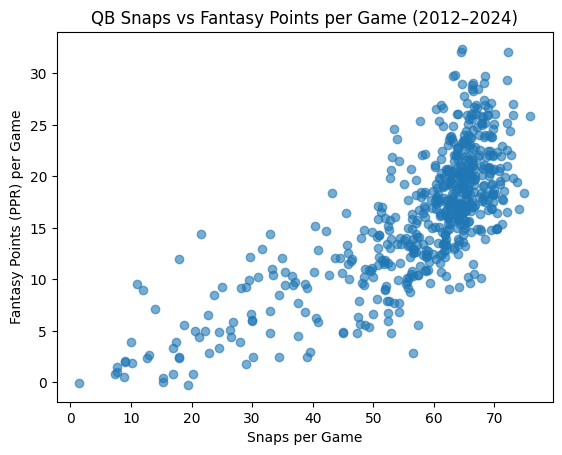

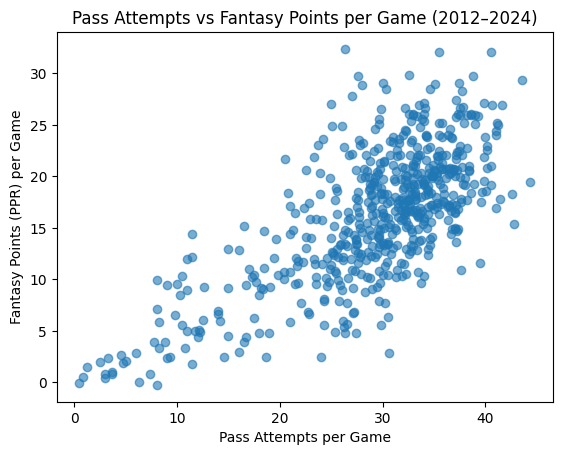

In [ ]:
# Graphs for QBs
plt.scatter(df_qbs['snaps_per_game'], df_qbs['fantasy_points_ppr_per_game'], alpha=0.6)
plt.xlabel('Snaps per Game')
plt.ylabel('Fantasy Points (PPR) per Game')
plt.title('QB Snaps vs Fantasy Points per Game (2012–2024)')
plt.show()


plt.scatter(df_qbs['pass_attempts_per_game'], df_qbs['fantasy_points_ppr_per_game'], alpha=0.6)
plt.xlabel('Pass Attempts per Game')
plt.ylabel('Fantasy Points (PPR) per Game')
plt.title('Pass Attempts vs Fantasy Points per Game (2012–2024)')
plt.show()

                                 OLS Regression Results                                
Dep. Variable:     fantasy_points_ppr_per_game   R-squared:                       0.067
Model:                                     OLS   Adj. R-squared:                  0.065
Method:                          Least Squares   F-statistic:                     41.95
Date:                         Fri, 12 Dec 2025   Prob (F-statistic):           1.98e-10
Time:                                 22:07:07   Log-Likelihood:                -1915.4
No. Observations:                          590   AIC:                             3835.
Df Residuals:                              588   BIC:                             3844.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

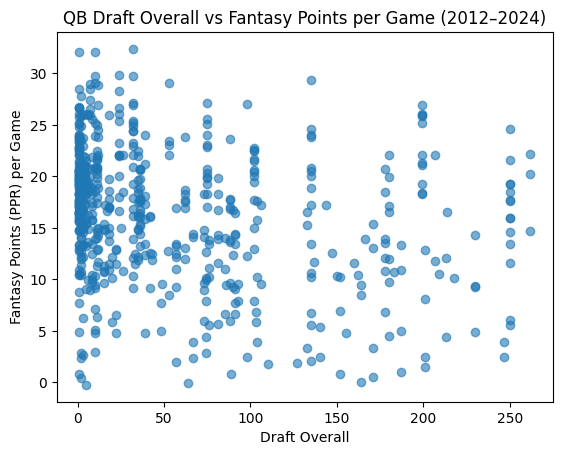

324
Number of QBs with > 100 career games: 76


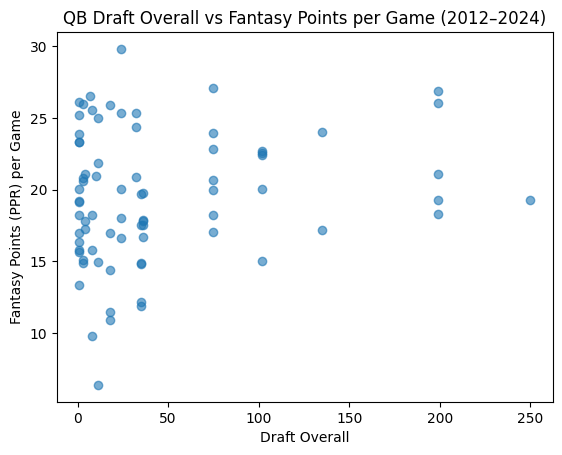

In [ ]:
# Define your independent variable (Draft)
draft_vars = ['draft_ovr']

# Dependent variable
y = df_qbs['fantasy_points_ppr_per_game']

# Model: Draft only
X = sm.add_constant(df_qbs[draft_vars])
model = sm.OLS(y, X).fit()

# Print results
print(model.summary())

# Extract key info for appendix
draft_results = pd.DataFrame({
    'Variable': ['Constant', 'Draft Overall'],
    'Coefficient': [f"{model.params['const']:.4f}", f"{model.params['draft_ovr']:.4f}"],
    'Std. Error': [f"{model.bse['const']:.4f}", f"{model.bse['draft_ovr']:.4f}"],
    'P-value': [f"{model.pvalues['const']:.4f}", f"{model.pvalues['draft_ovr']:.4f}"]
})

print("\nUnivariate Regression - Draft Position on Fantasy Points")
print("="*70)
print(draft_results.to_string(index=False))
print("="*70)
print(f"R²: {model.rsquared:.3f}")
print(f"Adj. R²: {model.rsquared_adj:.3f}")
print(f"N: {int(model.nobs)}")
draft_results.to_csv('appendix_table_a3.csv', index=False)

# All qbs
plt.scatter(df_qbs['draft_ovr'], df_qbs['fantasy_points_ppr_per_game'], alpha=0.6)
plt.xlabel('Draft Overall')
plt.ylabel('Fantasy Points (PPR) per Game')
plt.title('QB Draft Overall vs Fantasy Points per Game (2012–2024)')
plt.show()

# QBs with only greater than a 100 games played throughout career
print(len(df[df['games_played_career'] > 100]))
df_qbs_filtered_career_games = df_qbs[df_qbs['games_played_career'] > 100]
print(f"Number of QBs with > 100 career games: {len(df_qbs_filtered_career_games)}")
plt.scatter(df_qbs_filtered_career_games['draft_ovr'], df_qbs_filtered_career_games['fantasy_points_ppr_per_game'], alpha=0.6)
plt.xlabel('Draft Overall')
plt.ylabel('Fantasy Points (PPR) per Game')
plt.title('QB Draft Overall vs Fantasy Points per Game (2012–2024)')
plt.show()

                                 OLS Regression Results                                
Dep. Variable:     fantasy_points_ppr_per_game   R-squared:                       0.503
Model:                                     OLS   Adj. R-squared:                  0.502
Method:                          Least Squares   F-statistic:                     595.5
Date:                         Fri, 12 Dec 2025   Prob (F-statistic):           2.27e-91
Time:                                 22:07:27   Log-Likelihood:                -1729.4
No. Observations:                          590   AIC:                             3463.
Df Residuals:                              588   BIC:                             3472.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

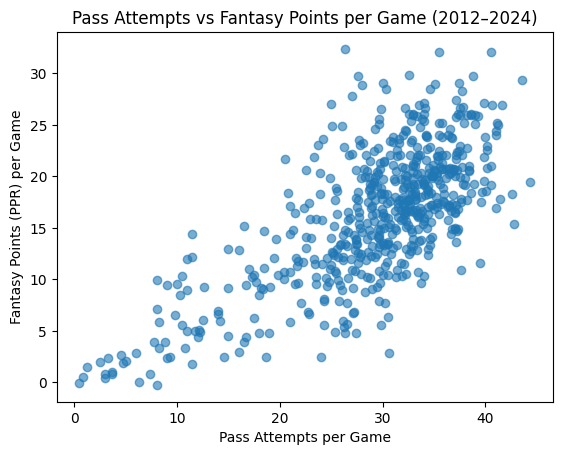


passer_rating Univariate Regression:
                            OLS Regression Results                            
Dep. Variable:          passer_rating   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     31.31
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           3.38e-08
Time:                        22:07:27   Log-Likelihood:                -2445.0
No. Observations:                 590   AIC:                             4894.
Df Residuals:                     588   BIC:                             4903.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [ ]:
volume_vars = [
    'pass_attempts_per_game', 'scrambles_per_game',
    'redzone_pass_attempts_per_game', 'goal_to_go_pass_attempts_per_game',
    'snaps_per_game'
]

efficiency_vars = [
    'passer_rating', 'passing_air_yards_per_attempt', 'completion_percentage',
    'completion_percentage_redzone', 'completion_percentage_goal_to_go'
]

experience_vars = [
    'years_exp', 'games_played_career'
]

draft_vars = [
    'draft_ovr'
]

# Univariate Regression for pass_attempts on fantasy points per game
y = df_qbs['fantasy_points_ppr_per_game']
X = sm.add_constant(df_qbs['pass_attempts_per_game'])
model = sm.OLS(y, X).fit()
print(model.summary())

# Extract key info for table
pass_attempts_univariate = pd.DataFrame({
    'Variable': ['Constant', 'Pass Attempts Per Game'],
    'Coefficient': [f"{model.params['const']:.4f}", f"{model.params['pass_attempts_per_game']:.4f}"],
    'Std. Error': [f"{model.bse['const']:.4f}", f"{model.bse['pass_attempts_per_game']:.4f}"],
    'P-value': [f"{model.pvalues['const']:.4f}", f"{model.pvalues['pass_attempts_per_game']:.4f}"]
})

print("\nTable A#: Univariate Regression - Pass Attempts Per Game on Fantasy Points")
print("="*75)
print(pass_attempts_univariate.to_string(index=False))
print("="*75)
print(f"R²: {model.rsquared:.3f}")
print(f"Adj. R²: {model.rsquared_adj:.3f}")
print(f"N: {int(model.nobs)}")

# Save to CSV
pass_attempts_univariate.to_csv('pass_attempts_univariate.csv', index=False)


# Visualize pass attempts per game on fantasy points per game
plt.scatter(df_qbs['pass_attempts_per_game'], df_qbs['fantasy_points_ppr_per_game'], alpha=0.6)
plt.xlabel('Pass Attempts per Game')
plt.ylabel('Fantasy Points (PPR) per Game')
plt.title('Pass Attempts vs Fantasy Points per Game (2012–2024)')
plt.show()

# Run each univariate regression of each efficiency metric on pass attempts per game
# Store each slope coefficient in a dictionary and display at the end
efficiency_slopes = {}
for var in efficiency_vars:
    y = df_qbs[var]
    X = sm.add_constant(df_qbs['pass_attempts_per_game'])
    model = sm.OLS(y, X).fit()
    efficiency_slopes[var] = model.params['pass_attempts_per_game']
    print(f"\n{var} Univariate Regression:")
    print(model.summary())

print("\nEfficiency Slopes:")
for var, slope in efficiency_slopes.items():
    print(f"{var}: {slope}")

results_summary = []

for var in efficiency_vars:
    y = df_qbs[var]
    X = sm.add_constant(df_qbs['pass_attempts_per_game'])
    model = sm.OLS(y, X).fit()

    results_summary.append({
        'Efficiency Metric': var.replace('_', ' ').title(),
        'Coefficient': f"{model.params['pass_attempts_per_game']:.4f}",
        'Std. Error': f"{model.bse['pass_attempts_per_game']:.4f}",
        'P-value': f"{model.pvalues['pass_attempts_per_game']:.4f}",
        'R²': f"{model.rsquared:.3f}"
    })

# Create DataFrame
summary_table = pd.DataFrame(results_summary)
print("\nUnivariate Regressions of Each Efficiency Metric on Pass Attempts Per Game")
print("="*80)
print(summary_table.to_string(index=False))
print("="*80)
print("Note: Each row represents a separate regression with the efficiency metric as the")
print("dependent variable and pass attempts per game as the independent variable.")

summary_table.to_csv('appendix_table_.csv', index=False)


In [ ]:
# Test if conditional correlation between pass attempts and efficiency is negative
# This regresses EFFICIENCY on PASS ATTEMPTS + OTHER VOLUME METRICS

efficiency_vars = ['passer_rating', 'passing_air_yards_per_attempt', 'completion_percentage',
                   'completion_percentage_redzone', 'completion_percentage_goal_to_go']

volume_vars = ['pass_attempts_per_game', 'scrambles_per_game',
               'redzone_pass_attempts_per_game', 'goal_to_go_pass_attempts_per_game',
               'snaps_per_game']

# For each efficiency metric, regress it on ALL volume variables
for eff_var in efficiency_vars:
    y = df_qbs[eff_var]
    X = df_qbs[volume_vars]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    print(f"\n{'='*60}")
    print(f"{eff_var} regressed on all volume metrics")
    print(f"{'='*60}")
    print(f"Pass attempts coefficient: {model.params['pass_attempts_per_game']:.4f}")
    print(f"Standard error: {model.bse['pass_attempts_per_game']:.4f}")
    print(f"P-value: {model.pvalues['pass_attempts_per_game']:.4f}")


# Create a clean summary table for conditional correlations
conditional_results = []

for eff_var in efficiency_vars:
    y = df_qbs[eff_var]
    X = df_qbs[volume_vars]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    conditional_results.append({
        'Efficiency Metric': eff_var.replace('_', ' ').title(),
        'Pass Attempts Coef.': f"{model.params['pass_attempts_per_game']:.4f}",
        'Std. Error': f"{model.bse['pass_attempts_per_game']:.4f}",
        'P-value': f"{model.pvalues['pass_attempts_per_game']:.4f}",
        'R²': f"{model.rsquared:.3f}"
    })

# Create DataFrame
conditional_table = pd.DataFrame(conditional_results)
print("\nTable A2: Conditional Regressions - Efficiency Metrics on All Volume Statistics")
print("="*90)
print(conditional_table.to_string(index=False))
print("="*90)

# Save to outputs
conditional_table.to_csv('appendix_table_a2.csv', index=False)


passer_rating regressed on all volume metrics
Pass attempts coefficient: -1.1395
Standard error: 0.2174
P-value: 0.0000

passing_air_yards_per_attempt regressed on all volume metrics
Pass attempts coefficient: -0.0339
Standard error: 0.0204
P-value: 0.0968

completion_percentage regressed on all volume metrics
Pass attempts coefficient: -0.0010
Standard error: 0.0009
P-value: 0.2611

completion_percentage_redzone regressed on all volume metrics
Pass attempts coefficient: 0.0027
Standard error: 0.0024
P-value: 0.2543

completion_percentage_goal_to_go regressed on all volume metrics
Pass attempts coefficient: 0.0024
Standard error: 0.0039
P-value: 0.5463

Table A2: Conditional Regressions - Efficiency Metrics on All Volume Statistics
               Efficiency Metric Pass Attempts Coef. Std. Error P-value    R²
                   Passer Rating             -1.1395     0.2174  0.0000 0.239
   Passing Air Yards Per Attempt             -0.0339     0.0204  0.0968 0.136
           Completion P

In [ ]:
# OLS univariate of fantasy points per game on snaps per game for running backs
y = df_rbs['fantasy_points_ppr_per_game']
X = sm.add_constant(df_rbs['snaps_per_game'])
model = sm.OLS(y, X).fit()
print(model.summary())

# OLS univariate of fantasy points per game on snaps per game for running backs
y = df_rbs['fantasy_points_ppr_per_game']
X = sm.add_constant(df_rbs['snaps_per_game'])
model = sm.OLS(y, X).fit()

# Extract key info for appendix table
rb_snaps_results = pd.DataFrame({
    'Variable': ['Constant', 'Snaps Per Game'],
    'Coefficient': [f"{model.params['const']:.4f}", f"{model.params['snaps_per_game']:.4f}"],
    'Std. Error': [f"{model.bse['const']:.4f}", f"{model.bse['snaps_per_game']:.4f}"],
    'P-value': [f"{model.pvalues['const']:.4f}", f"{model.pvalues['snaps_per_game']:.4f}"]
})

print("\nTable AZ: Univariate Regression - RB Snaps Per Game on Fantasy Points")
print("="*70)
print(rb_snaps_results.to_string(index=False))
print("="*70)
print(f"R²: {model.rsquared:.3f}")
print(f"Adj. R²: {model.rsquared_adj:.3f}")
print(f"N: {int(model.nobs)}")

# Save to CSV
rb_snaps_results.to_csv('appendix_table_rb_snaps_vs_fppg.csv', index=False)

                                 OLS Regression Results                                
Dep. Variable:     fantasy_points_ppr_per_game   R-squared:                       0.766
Model:                                     OLS   Adj. R-squared:                  0.766
Method:                          Least Squares   F-statistic:                     4368.
Date:                         Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                                 08:31:08   Log-Likelihood:                -3136.7
No. Observations:                         1335   AIC:                             6277.
Df Residuals:                             1333   BIC:                             6288.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

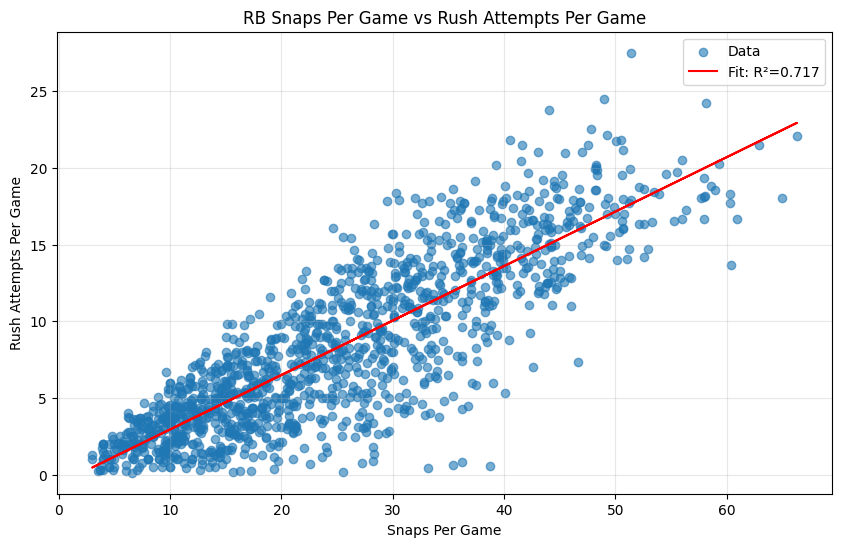

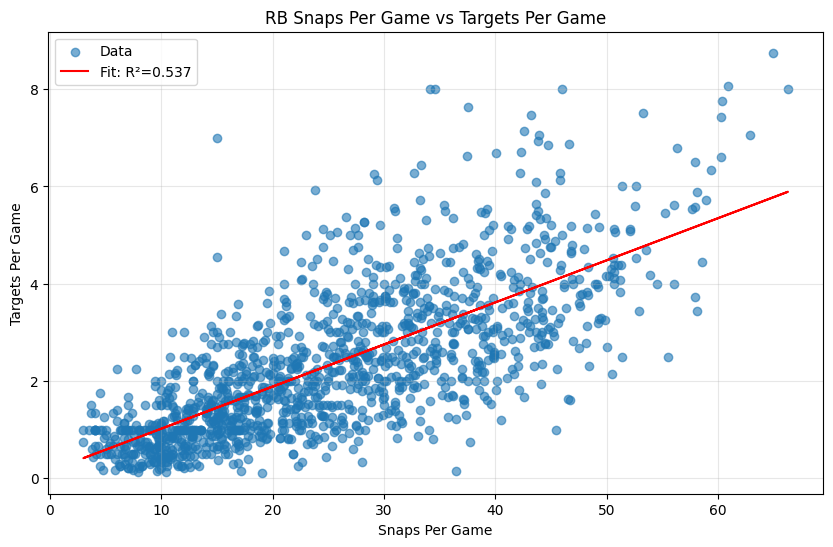

In [ ]:
# Scatter plot of snaps per game vs rush attempts per game for running backs
plt.figure(figsize=(10, 6))
plt.scatter(df_rbs['snaps_per_game'], df_rbs['rush_attempts_per_game'], alpha=0.6, label='Data')

# Add regression line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_rbs['snaps_per_game'], df_rbs['rush_attempts_per_game'])
line = slope * df_rbs['snaps_per_game'] + intercept
plt.plot(df_rbs['snaps_per_game'], line, color='red', label=f'Fit: R²={r_value**2:.3f}')

plt.xlabel('Snaps Per Game')
plt.ylabel('Rush Attempts Per Game')
plt.title('RB Snaps Per Game vs Rush Attempts Per Game')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Same thing but with snaps per game vs targets per game
plt.figure(figsize=(10, 6))
plt.scatter(df_rbs['snaps_per_game'], df_rbs['targets_per_game'], alpha=0.6, label='Data')

# Add regression line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_rbs['snaps_per_game'], df_rbs['targets_per_game'])
line = slope * df_rbs['snaps_per_game'] + intercept
plt.plot(df_rbs['snaps_per_game'], line, color='red', label=f'Fit: R²={r_value**2:.3f}')

plt.xlabel('Snaps Per Game')
plt.ylabel('Targets Per Game')
plt.title('RB Snaps Per Game vs Targets Per Game')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

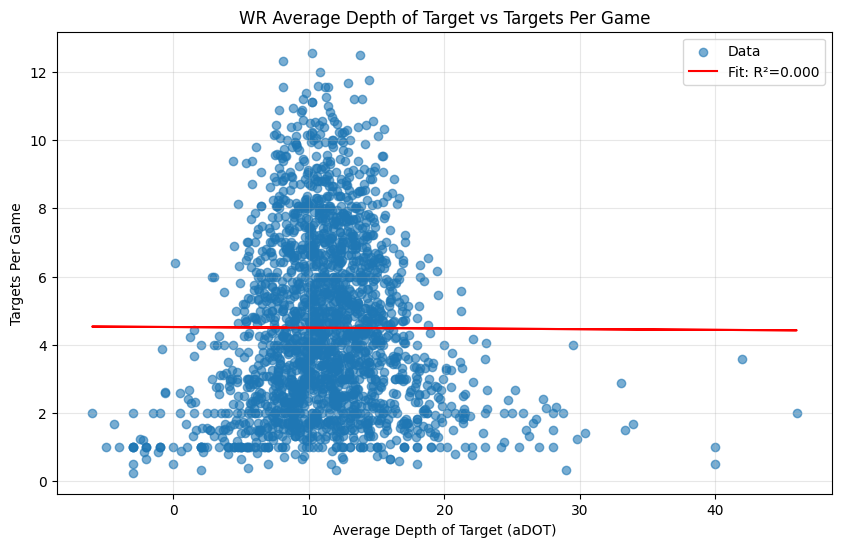

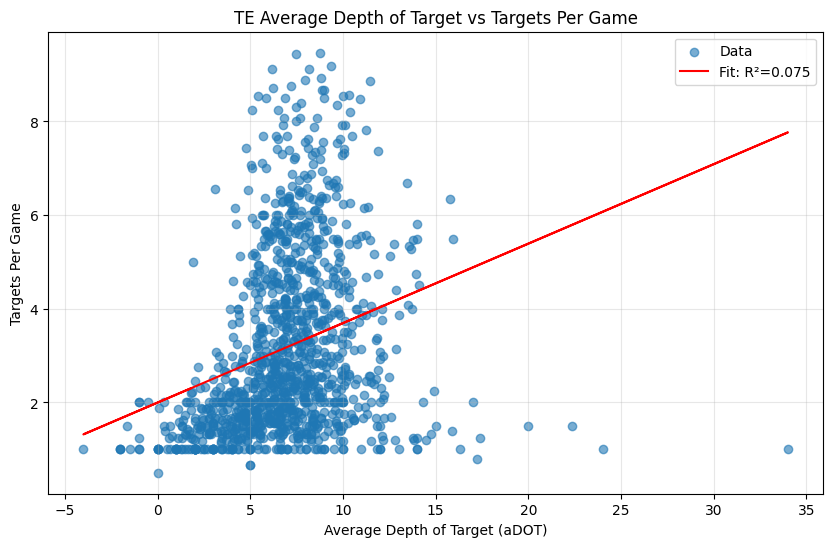

In [ ]:
# For WRs and TEs, respectively
# Scatter plots of adot vs targets

# Wide Receivers
plt.figure(figsize=(10, 6))
plt.scatter(df_wrs['adot'], df_wrs['targets_per_game'], alpha=0.6, label='Data')

# Add regression line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_wrs['adot'], df_wrs['targets_per_game'])
line = slope * df_wrs['adot'] + intercept
plt.plot(df_wrs['adot'], line, color='red', label=f'Fit: R²={r_value**2:.3f}')

plt.xlabel('Average Depth of Target (aDOT)')
plt.ylabel('Targets Per Game')
plt.title('WR Average Depth of Target vs Targets Per Game')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figure_wr_adot_targets.png', dpi=300, bbox_inches='tight')
plt.show()

# Tight Ends
plt.figure(figsize=(10, 6))
plt.scatter(df_tes['adot'], df_tes['targets_per_game'], alpha=0.6, label='Data')

# Add regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_tes['adot'], df_tes['targets_per_game'])
line = slope * df_tes['adot'] + intercept
plt.plot(df_tes['adot'], line, color='red', label=f'Fit: R²={r_value**2:.3f}')

plt.xlabel('Average Depth of Target (aDOT)')
plt.ylabel('Targets Per Game')
plt.title('TE Average Depth of Target vs Targets Per Game')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figure_te_adot_targets.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# WRs: Regress fantasy points per game on adot
y = df_wrs['fantasy_points_ppr_per_game']
X = sm.add_constant(df_wrs['adot'])
model_wr = sm.OLS(y, X).fit()

# Extract key info for WR table
wr_adot_results = pd.DataFrame({
    'Variable': ['Constant', 'Average Depth of Target'],
    'Coefficient': [f"{model_wr.params['const']:.4f}", f"{model_wr.params['adot']:.4f}"],
    'Std. Error': [f"{model_wr.bse['const']:.4f}", f"{model_wr.bse['adot']:.4f}"],
    'P-value': [f"{model_wr.pvalues['const']:.4f}", f"{model_wr.pvalues['adot']:.4f}"]
})

print("\nTable A#: WR Univariate Regression - aDOT on Fantasy Points Per Game")
print("="*75)
print(wr_adot_results.to_string(index=False))
print("="*75)
print(f"R²: {model_wr.rsquared:.3f}")
print(f"Adj. R²: {model_wr.rsquared_adj:.3f}")
print(f"N: {int(model_wr.nobs)}")

# Save WR table
wr_adot_results.to_csv('wr_adot_fppg.csv', index=False)

# TEs: Regress fantasy points per game on adot
y = df_tes['fantasy_points_ppr_per_game']
X = sm.add_constant(df_tes['adot'])
model_te = sm.OLS(y, X).fit()

# Extract key info for TE table
te_adot_results = pd.DataFrame({
    'Variable': ['Constant', 'Average Depth of Target'],
    'Coefficient': [f"{model_te.params['const']:.4f}", f"{model_te.params['adot']:.4f}"],
    'Std. Error': [f"{model_te.bse['const']:.4f}", f"{model_te.bse['adot']:.4f}"],
    'P-value': [f"{model_te.pvalues['const']:.4f}", f"{model_te.pvalues['adot']:.4f}"]
})

print("\nTable A#: TE Univariate Regression - aDOT on Fantasy Points Per Game")
print("="*75)
print(te_adot_results.to_string(index=False))
print("="*75)
print(f"R²: {model_te.rsquared:.3f}")
print(f"Adj. R²: {model_te.rsquared_adj:.3f}")
print(f"N: {int(model_te.nobs)}")

# Save TE table
te_adot_results.to_csv('te_adot_fppg.csv', index=False)


Table A#: WR Univariate Regression - aDOT on Fantasy Points Per Game
               Variable Coefficient Std. Error P-value
               Constant      7.4606     0.2834  0.0000
Average Depth of Target      0.0033     0.0233  0.8877
R²: 0.000
Adj. R²: -0.000
N: 2120

Table A#: TE Univariate Regression - aDOT on Fantasy Points Per Game
               Variable Coefficient Std. Error P-value
               Constant      3.1274     0.2437  0.0000
Average Depth of Target      0.3302     0.0321  0.0000
R²: 0.082
Adj. R²: 0.081
N: 1187
